In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

c:\Users\dres\.conda\envs\Flow\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#--------------------------------------------------------------------------------
# Descargamos el conjunto de datos de Fashion MNIST de Zalando
#--------------------------------------------------------------------------------
datos, metadatos = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

In [3]:
#--------------------------------------------------------------------------------
# Mostramos los metadatos para ver que trae el conjunto de datos
#--------------------------------------------------------------------------------
metadatos

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=1.0.0,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    urls=['https://github.com/zalandoresearch/fashion-mnist'],
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume  

In [4]:
#--------------------------------------------------------------------------------
# Obtenemos en variables separadas los datos de entrenamiento (60k) y pruebas (10k)
#--------------------------------------------------------------------------------
datos_entrenamiento, datos_pruebas = datos['train'], datos['test']

In [5]:
#--------------------------------------------------------------------------------
# Etiquetas de las 10 categorias posibles
#--------------------------------------------------------------------------------
nombres_clases = metadatos.features['label'].names
nombres_clases

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
#--------------------------------------------------------------------------------
# Renombramos los tipos de datos
#--------------------------------------------------------------------------------
nombres_clases = [ 'Camiseta/top', 'Pantalón', 'Jersey', 'Vestido', 'Abrigo', 'Sandalia', 'Camisa', 'Zapailla de deporte', 'Bolsa', 'Botín' ]
nombres_clases

['Camiseta/top',
 'Pantalón',
 'Jersey',
 'Vestido',
 'Abrigo',
 'Sandalia',
 'Camisa',
 'Zapailla de deporte',
 'Bolsa',
 'Botín']

In [7]:
#--------------------------------------------------------------------------------
# Funcion de normalizacion para los datos (Pasar de 0-255 a 0-1)
# Hace que la red aprenda mejor y mas rapido
#--------------------------------------------------------------------------------
def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes /= 255 #Aqui lo pasa de 0-255 a 0-1
  return imagenes, etiquetas

#--------------------------------------------------------------------------------
# Normalizamos los datos de entrenamiento y pruebas con la funcion que hicimos
#--------------------------------------------------------------------------------
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

#--------------------------------------------------------------------------------
# Agregamos a cache (usar memoria en lugar de disco, entrenamiento mas rapido)
#--------------------------------------------------------------------------------
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

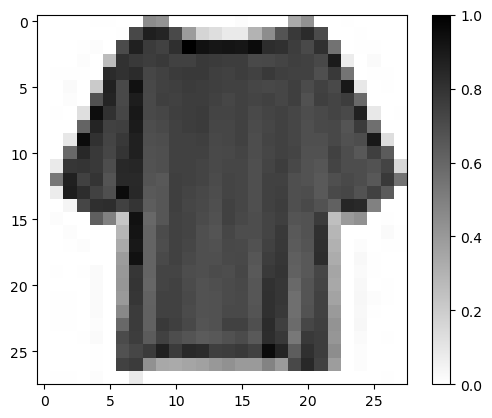

In [8]:
#--------------------------------------------------------------------------------
# Mostramos una imagen de los datos de pruebas, de momento mostremos la primera
#--------------------------------------------------------------------------------
for imagen, etiqueta in datos_entrenamiento.take(1):
  break
imagen = imagen.numpy().reshape((28,28)) #Redimensionar, cosas de tensores, lo veremos despues

import matplotlib.pyplot as plt

#--------------------------------------------------------------------------------
# Mostramos una imagen
#--------------------------------------------------------------------------------
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

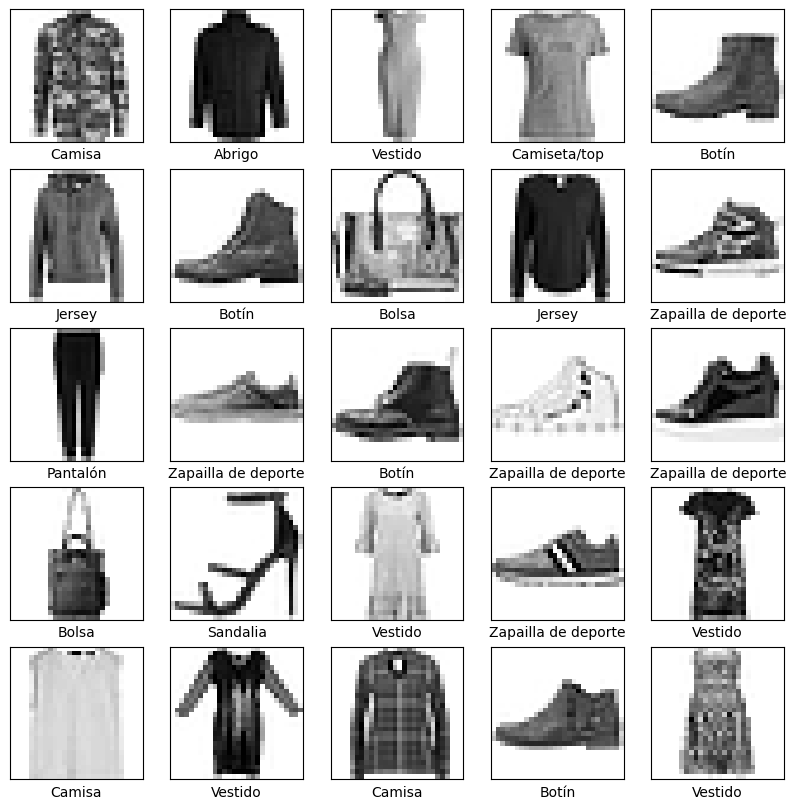

In [9]:
#--------------------------------------------------------------------------------
# Dibujamos ahora más
#--------------------------------------------------------------------------------
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = imagen.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(nombres_clases[etiqueta])
plt.show()

In [10]:
#--------------------------------------------------------------------------------
# Crear el modelo Denso
#--------------------------------------------------------------------------------
modeloDenso = tf.keras.Sequential([
  tf.keras.layers.Flatten( input_shape = (28,28,1)), #1 - blanco y negro
  tf.keras.layers.Dense( 50, activation = 'relu' ),
  tf.keras.layers.Dense( 50, activation = 'relu' ),
  tf.keras.layers.Dense( 10, activation = 'softmax' ) #Para redes de clasificacion
])

#--------------------------------------------------------------------------------
# Creamos el modelo Convolucional
#--------------------------------------------------------------------------------
modeloConvolucional = tf.keras.Sequential([
  tf.keras.layers.Conv2D( 32, ( 3, 3 ), input_shape = ( 28, 28, 1 ), activation = 'relu' ),
  tf.keras.layers.MaxPooling2D( 2, 2 ),             # 2,2 es el tamano de la matriz
  tf.keras.layers.Dropout( 0.25 ),

  tf.keras.layers.Conv2D( 64, ( 3, 3 ), activation = 'relu' ),
  tf.keras.layers.MaxPooling2D( 2, 2 ),             # 2,2 es el tamano de la matriz
  tf.keras.layers.Dropout( 0.25 ),

  tf.keras.layers.Flatten(),      # Aplanamiento
  tf.keras.layers.Dense( 50, activation = 'relu' ),
  tf.keras.layers.Dense( 10, activation = 'softmax' )
])

In [11]:
#--------------------------------------------------------------------------------
# Compilamos los modelos Denso y Convolucional
#--------------------------------------------------------------------------------
modeloDenso.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

modeloConvolucional.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [12]:
#--------------------------------------------------------------------------------
# Los numeros de datos en entrenamiento y pruebas (60k y 10k)
#--------------------------------------------------------------------------------
num_ej_entrenamiento = metadatos.splits["train"].num_examples
num_ej_pruebas = metadatos.splits["test"].num_examples
print(num_ej_entrenamiento)
print(num_ej_pruebas)

60000
10000


In [13]:
#--------------------------------------------------------------------------------
# El trabajo por lotes permite que entrenamientos con gran cantidad de datos se haga de manera mas eficiente
#--------------------------------------------------------------------------------
TAMANO_LOTE = 32 #8  #32

#--------------------------------------------------------------------------------
# Shuffle y repeat hacen que los datos esten mezclados de manera aleatoria para que la red
# no se vaya a aprender el orden de las cosas
#--------------------------------------------------------------------------------
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

In [14]:
import math
ACIERTO = 0.95

print( 'Entrenando la red Densa ...' )
#--------------------------------------------------------------------------------
# Entrenamos ahora el modelo Denso
#--------------------------------------------------------------------------------
historial = modeloDenso.fit(datos_entrenamiento, epochs = 1, steps_per_epoch = math.ceil(num_ej_entrenamiento/TAMANO_LOTE))
while( historial.history[ 'accuracy' ][0] < ACIERTO ):
    historial = modeloDenso.fit(datos_entrenamiento, epochs = 1, steps_per_epoch = math.ceil(num_ej_entrenamiento/TAMANO_LOTE))
print( 'Fin del entrenamiento de la red Densa.' )

print( 'Entrenando la red Convolucional ...' )
#--------------------------------------------------------------------------------
# Entrenamos ahora el modelo Convolucional
#--------------------------------------------------------------------------------
historial = modeloConvolucional.fit(datos_entrenamiento, epochs = 1, steps_per_epoch = math.ceil(num_ej_entrenamiento/TAMANO_LOTE))
while( historial.history[ 'accuracy' ][0] < ACIERTO ):
    historial = modeloConvolucional.fit(datos_entrenamiento, epochs = 1, steps_per_epoch = math.ceil(num_ej_entrenamiento/TAMANO_LOTE))
print( 'Fin del entrenamiento de la red Convolucional.' )

Entrenando la red Densa ...
   1/1875 [..............................] - ETA: 0s - loss: 0.1924 - accuracy: 0.9062WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0000s vs `on_train_batch_end` time: 0.0010s). Check your callbacks.


1875/1875 [==============================] - 2s 829us/step - loss: 0.1341 - accuracy: 0.9501
Fin del entrenamiento de la red Densa.
Entrenando la red Convolucional ...
1875/1875 [==============================] - 25s 13ms/step - loss: 0.1330 - accuracy: 0.9501
Fin del entrenamiento de la red Convolucional.


In [15]:
#--------------------------------------------------------------------------------
# Definimos las funciones asociadas a mostrar las predicciones con color azul (correcta) o roja (errónea)
#--------------------------------------------------------------------------------
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(10):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  prediccionesDenso         = modeloDenso.predict(         imagenes_prueba )
  prediccionesConvolucional = modeloConvolucional.predict( imagenes_prueba )

def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real]),
                                color=color)

def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1])
  etiqueta_prediccion = np.argmax(arr_predicciones)

  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')

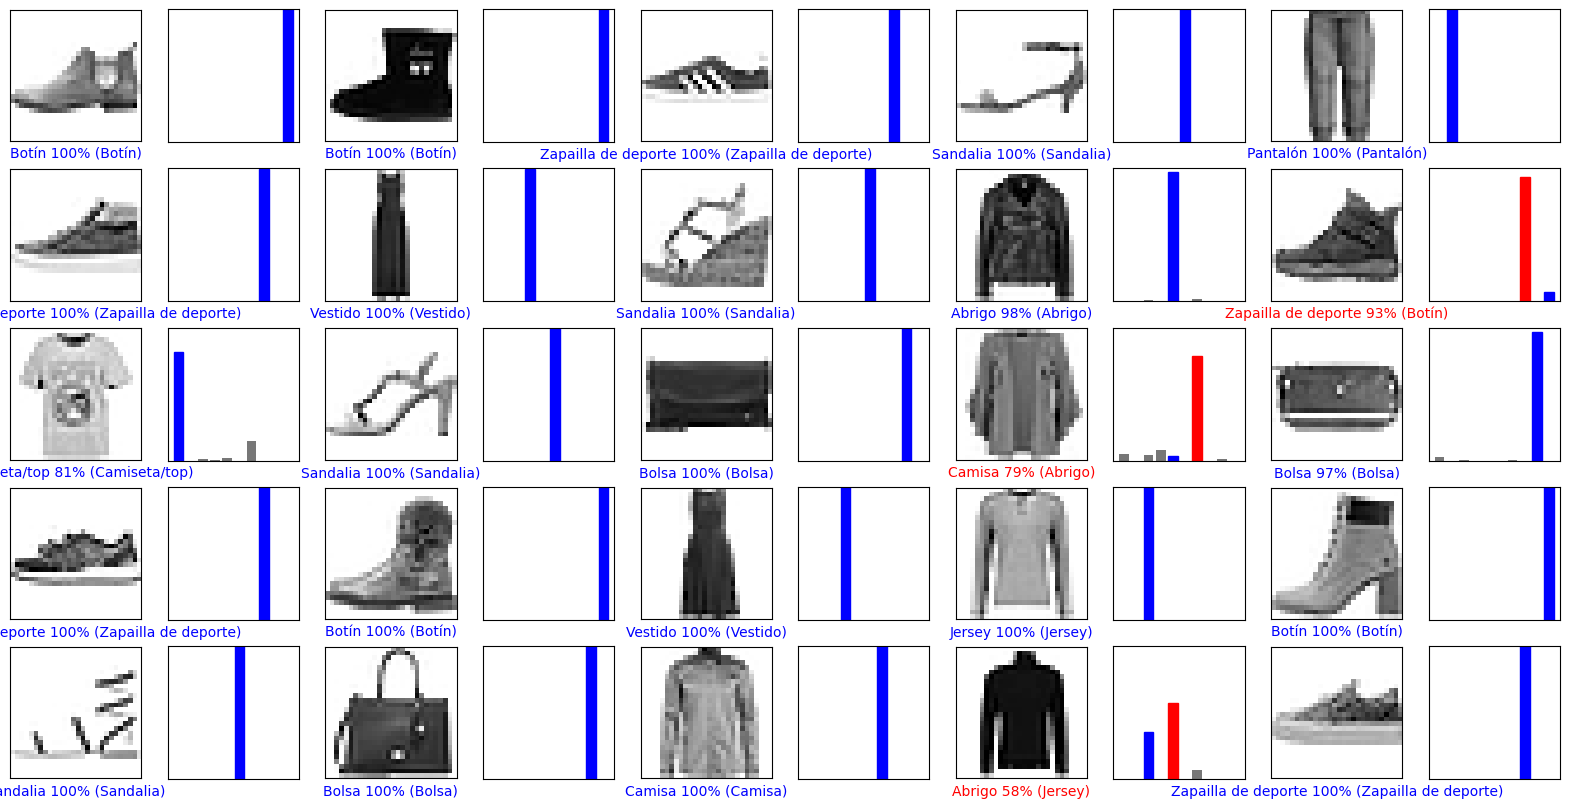

In [16]:
#--------------------------------------------------------------------------------
# Mostramos ahora las predicciones con el modelo Denso
#--------------------------------------------------------------------------------
filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, prediccionesDenso, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, prediccionesDenso, etiquetas_prueba)

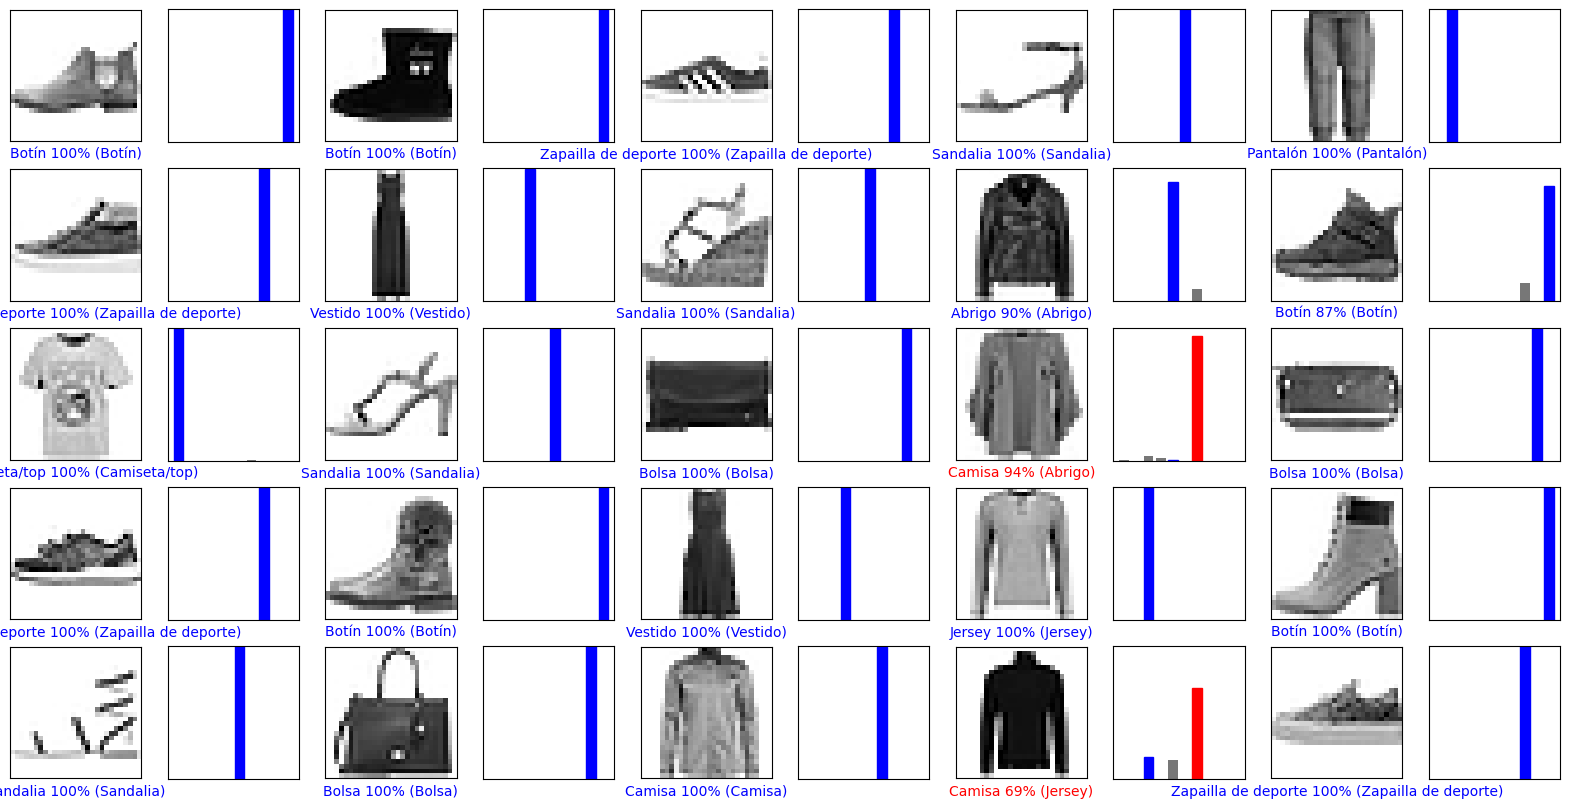

In [17]:
#--------------------------------------------------------------------------------
# Mostramos ahora las predicciones con el modelo Convolucional
#--------------------------------------------------------------------------------
filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, prediccionesConvolucional, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, prediccionesConvolucional, etiquetas_prueba)

In [18]:
#--------------------------------------------------------------------------------
# Probar una imagen suelta
#--------------------------------------------------------------------------------
imagen = imagenes_prueba[13] #AL ser la variable imagenes_prueba solo tiene lo que se le puso en el bloque anterior heheh
imagen = np.array([imagen])
prediccion = modeloDenso.predict(imagen)
print( "Prediccion: " + nombres_clases[np.argmax(prediccion[0])])
prediccion = modeloConvolucional.predict(imagen)
print( "Prediccion: " + nombres_clases[np.argmax(prediccion[0])])


Prediccion: Camisa
Prediccion: Camisa


In [19]:
#Exportacion del modelo a h5
modeloDenso.save( "modeloDenso.h5" )
modeloConvolucional.save("modeloConvolucional.h5")

tf.saved_model.save(modeloDenso, "modeloDenso_guardado" )
tf.saved_model.save(modeloConvolucional, "modeloConvolucional_guardado" )

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: modeloDenso_guardado\assets


INFO:tensorflow:Assets written to: modeloDenso_guardado\assets


INFO:tensorflow:Assets written to: modeloConvolucional_guardado\assets


INFO:tensorflow:Assets written to: modeloConvolucional_guardado\assets


In [20]:
#Instalar tensorflowjs para convertir el h5 a un modelo que pueda cargar tensorflowjs en un explorador
!pip install tensorflowjs

ERROR: Cannot install flax because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts



  Using cached flax-0.7.2-py3-none-any.whl.metadata (10.0 kB)
  Using cached jax-0.4.13.tar.gz (1.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
INFO: pip is looking at multiple versions of tensorflowjs to determine which version is compatible with other requirements. This could take a while.
  Using cached tensorflowjs-4.19.0-py3-none-any.whl.metadata (3.2 kB)
  Using cached tensorflowjs-4.18.0-py3-none-any.whl.metadata (3.2 kB)
  Using cached tensorflowjs-4.17.0-py3-none-any.whl.metadata (3.2 kB)
  Using cached tensorflowjs-4.16.0-py3-none-any.whl.metadata (3.2 kB)
  Using cached tensorflowjs-4.15.0-py3-none-any.whl.metadata (3.2 kB)
  Using cached tensorflowjs-4.14.0-py3-none-any.whl.metadata (3.2 

In [21]:
#Convertir el archivo h5 a formato de tensorflowjs
!mkdir tfjs_target_dir
!tensorflowjs_converter --input_format keras modelo_exportado.h5 tfjs_target_dir

Ya existe el subdirectorio o el archivo tfjs_target_dir.
"tensorflowjs_converter" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [22]:
#Veamos si si creo la carpeta
!ls

"ls" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [23]:
#Veamos el contenido de la carpeta
!ls tfjs_target_dir

"ls" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [24]:
#modelo_cargado = tf.keras.models.load_model( 'modeloDenso.h5' )
modelo_cargado = tf.keras.models.load_model( 'modeloConvolucional.h5' )

#modelo_cargado = tf.saved_model.load( "modeloDenso_guardado" )
#modelo_cargado = tf.saved_model.load( "modeloConvolucional_guardado" )
modelo_cargado

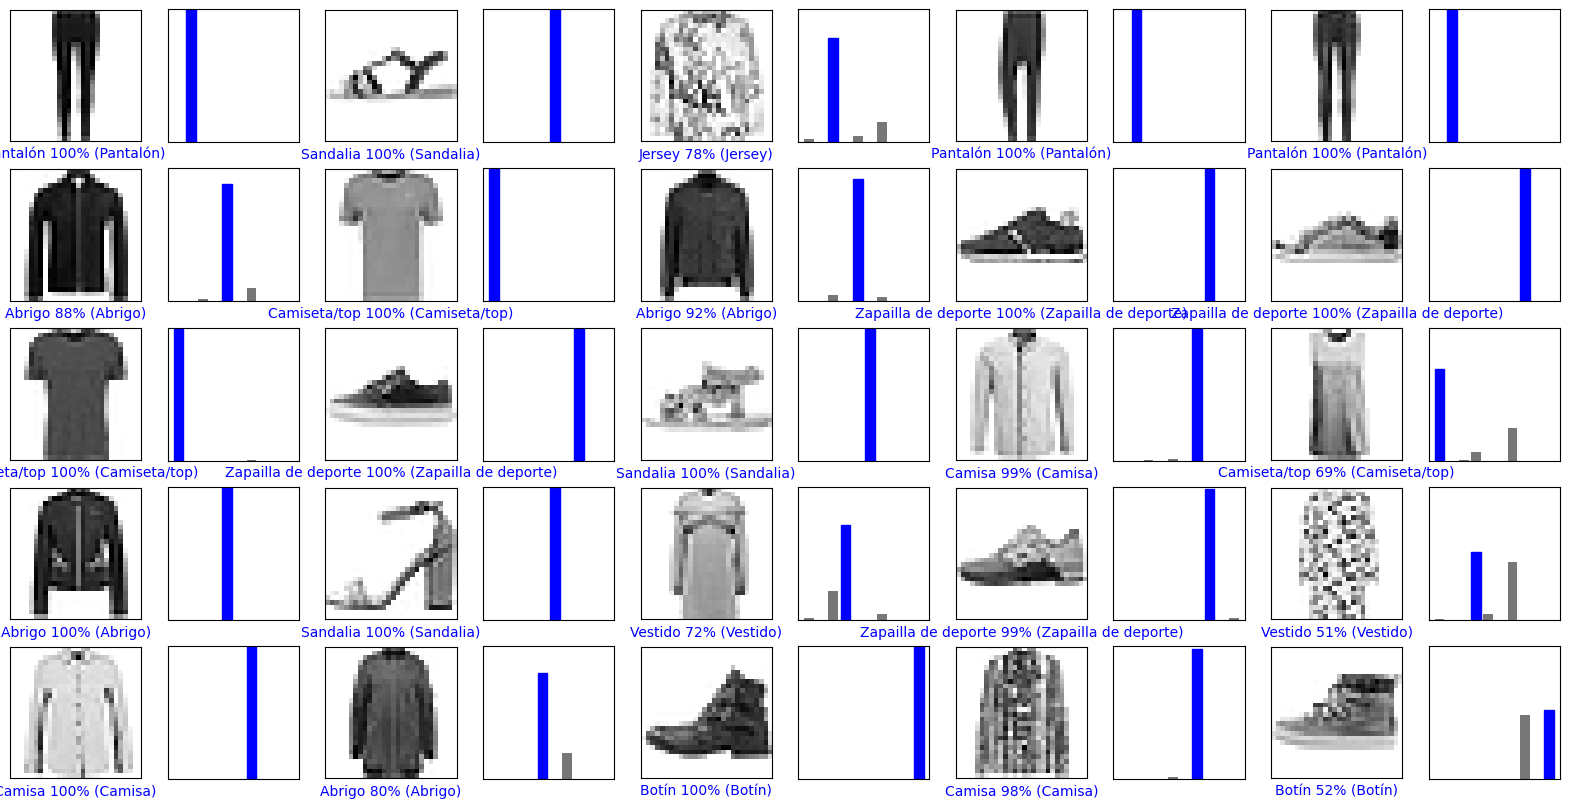

In [25]:
#Pintar una cuadricula con varias predicciones, y marcar si fue correcta (azul) o incorrecta (roja)
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(20):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo_cargado.predict(imagenes_prueba)

def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real]),
                                color=color)

def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1])
  etiqueta_prediccion = np.argmax(arr_predicciones)

  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')

filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)